In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, MaxPooling1D, Flatten
from keras.models import Sequential
import os
from keras.layers import Dense, Activation, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
import joblib
# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# how to use .h5 file
# https://www.tensorflow.org/tutorials/keras/save_and_load


import warnings
warnings.filterwarnings('ignore')

c:\Users\hyha1\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# 모든 데이터를 합친 데이터(정리된 데이터)
data = pd.read_csv('data/merge_all/merge_drop.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래년월일           5782 non-null   object 
 1   자동차용 경유 가격 (원)  5782 non-null   float64
 2   전월비(%)          5782 non-null   float64
 3   평균              5782 non-null   float64
 4   거래량             5782 non-null   float64
dtypes: float64(4), object(1)
memory usage: 226.0+ KB


In [4]:
# "배추가격"의 이동평균을 # 코드를 함수로 만든다. 당일 제외
def make_ma(df, col, ma_list):
    for ma in ma_list:
        df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean().shift(1)
    return df

# "배추가격"의 이동평균을 구한다
data = make_ma(data, '평균', [5, 20, 60, 300])

# # 거래량 컬럼 제거
data = data.drop(['거래량'], axis=1)

# "배추가격_N" 컬럼의 결측치를 제거한다
data = data.dropna()
data

,거래년월일,자동차용 경유 가격 (원),전월비(%),평균,평균_5MA,평균_20MA,평균_60MA,평균_300MA
300,2001-01-11,660.99,8.2,1900.0,1904.0,1826.500,2088.683333,4683.080000
301,2001-01-12,660.99,8.2,1900.0,1912.0,1823.000,2062.933333,4670.746667
302,2001-01-13,660.99,8.2,1900.0,1924.0,1824.000,2040.266667,4658.413333
303,2001-01-15,660.99,8.2,2040.0,1908.0,1829.500,2020.933333,4646.013333
304,2001-01-16,660.99,8.2,2160.0,1928.0,1844.000,2004.850000,4633.813333
...,...,...,...,...,...,...,...,...
5777,2022-11-24,1879.15,-8.0,6100.0,6422.0,7015.750,17688.383333,11945.515000
5778,2022-11-25,1879.15,-8.0,6100.0,6355.6,6908.150,17505.050000,11937.081667
5779,2022-11-28,1879.15,-8.0,5664.0,6172.0,6817.350,17234.383333,11924.265000
5780,2022-11-29,1879.15,-8.0,5592.0,6044.8,6710.925,16932.116667,11910.411667


In [5]:
# data 거래년월일 컬럼을 2022-10-30 까지만 사용
train = data[data['거래년월일'] <= '2022-10-31']
#y_train = data[data['거래년월일'] <= '2022-10-31']

# data 거래년월일 컬럼을 2022-10-30 일부터 사용
test = data[data['거래년월일'] > '2022-10-31']
#y_test = data[data['거래년월일'] > '2022-10-31']


In [6]:
# 데이터 나누기
train_X = train[['자동차용 경유 가격 (원)', '전월비(%)', '평균_5MA', '평균_20MA', '평균_60MA', '평균_300MA']]
train_Y = train['평균']
test_X = test[['자동차용 경유 가격 (원)', '전월비(%)', '평균_5MA', '평균_20MA', '평균_60MA', '평균_300MA']]
test_Y = test['평균']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)    


In [8]:
# 데이터 정규화 하기
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1)) # 2차원으로 만들어주기
y_test = scaler_y.transform(y_test.values.reshape(-1,1))

In [9]:
# 모델 만들기
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [10]:
# 예측
y_pred = xgb_model.predict(X_test)
        
# 평가
print('MSE :', mean_squared_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

MSE : 0.020540875992120265
R2 : 0.9790496185436741


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


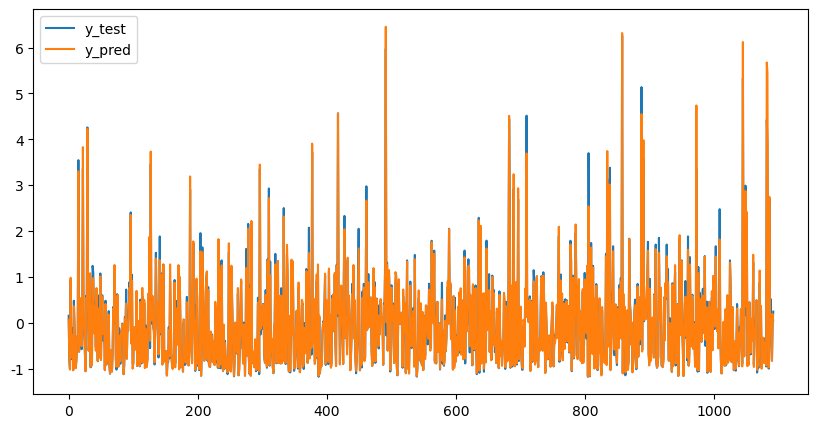

In [11]:
# 예측값과 실제값 비교
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [13]:
# 모델 저장
joblib.dump(xgb_model, 'model/xgboost_test2.pkl')

['model/xgboost_test2.pkl']

In [14]:
# 모델 불러오기
model_1 = joblib.load('model/xgboost_test2.pkl')

# 모델 예측
test_pre = model_1.predict(X_test)

In [15]:
test_pre

array([ 0.065123  , -0.81487626, -1.0209183 , ..., -0.82607305,
        0.19115496,  0.05196303], dtype=float32)

In [16]:
# 역정규화 
scaler_y.inverse_transform(test_pre.reshape(-1,1))

array([[7047.6006],
       [3344.139 ],
       [2477.0146],
       ...,
       [3297.0173],
       [7578.0034],
       [6992.217 ]], dtype=float32)

#

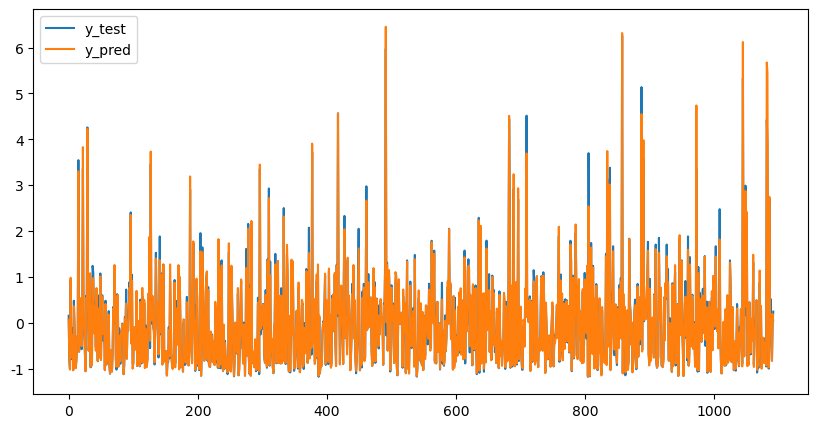

In [17]:
# 예측값과 실제값 비교
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='y_test')
plt.plot(test_pre, label='y_pred')
plt.legend()
plt.show()

In [18]:
scale_test = scaler_x.transform(test_X)
pred_test = model_1.predict(scale_test)

In [19]:
pred_test = scaler_y.inverse_transform(pred_test.reshape(-1,1))

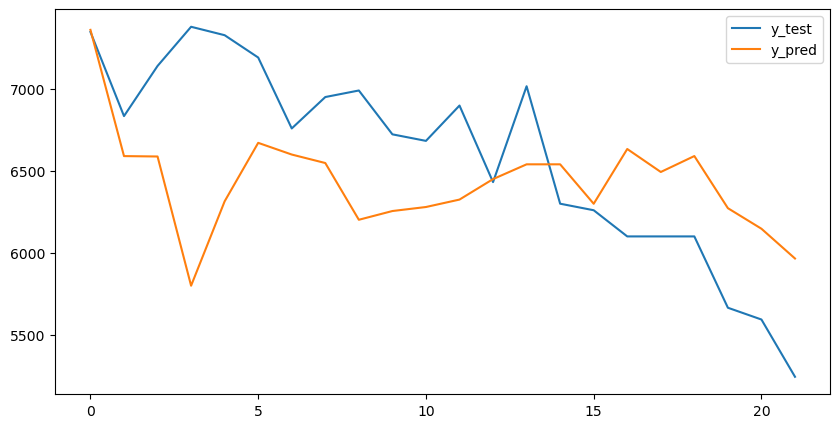

In [22]:
# 예측값과 실제값 비교
plt.figure(figsize=(10, 5))
plt.plot(test_Y.tolist(), label='y_test')
plt.plot(pred_test, label='y_pred')
plt.legend()
plt.show()

In [27]:
# 평가
print('MSE :', mean_squared_error(test_Y, pred_test))
print('R2 :', r2_score(test_Y, pred_test))

MSE : 357782.0641008832
R2 : -0.01997042202918209


In [13]:
dt

,자동차용 경유 가격 (원)
거래년월일,
2001-01-11,660.99
2001-01-12,660.99
2001-01-13,660.99
2001-01-15,660.99
2001-01-16,660.99
...,...
2022-11-24,1879.15
2022-11-25,1879.15
2022-11-28,1879.15


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


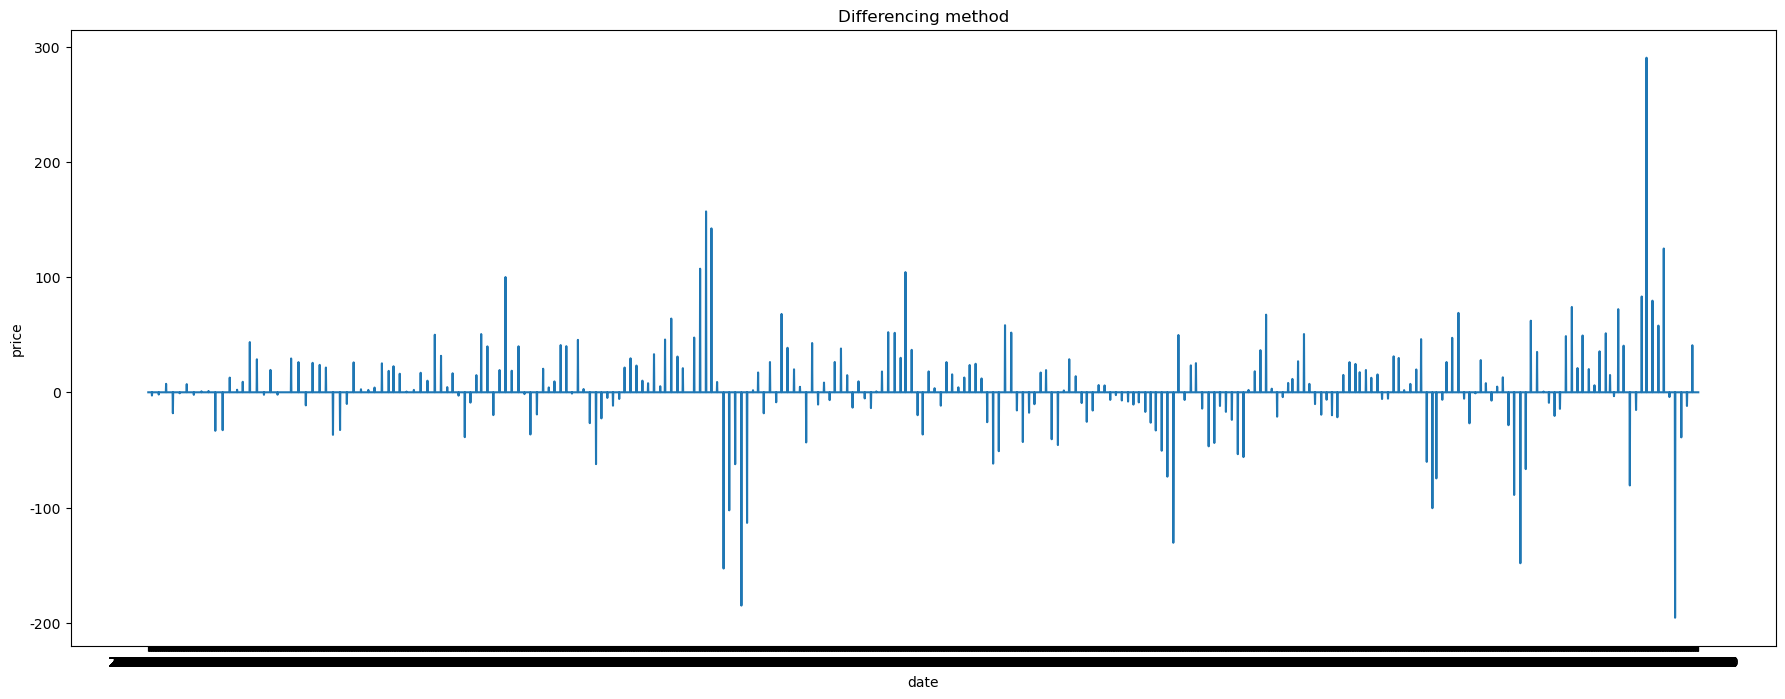

In [15]:
dt_diff = dt - dt.shift()
plt.figure(figsize=(22,8))
plt.plot(dt_diff)
plt.title('Differencing method')
plt.xlabel('date')
plt.ylabel('price')
plt.show()

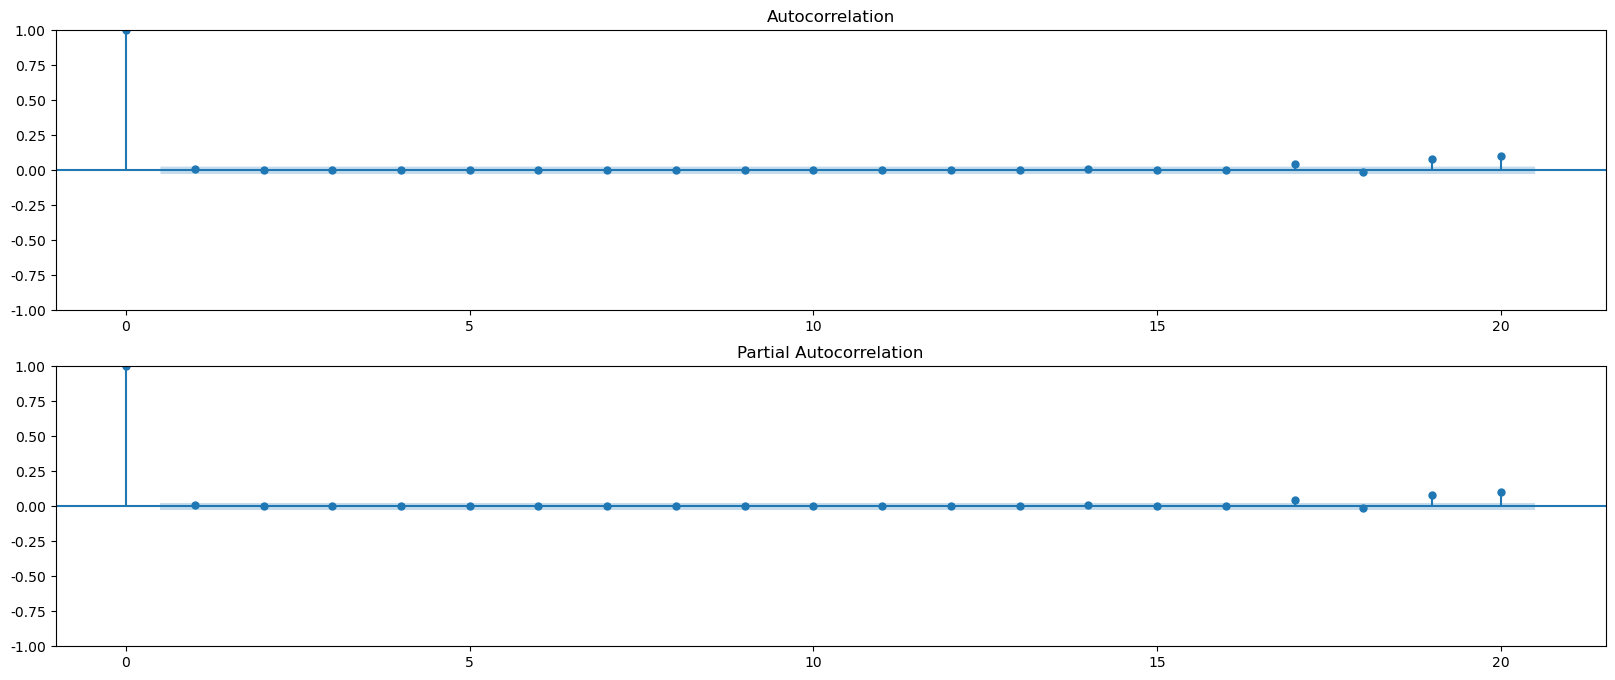

In [16]:
import statsmodels.api as sm
# ACF, PACF 그래프 그리기 (ARIMA 모형의 p와 q 값 결정)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dt_diff.iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dt_diff.iloc[1:], lags=20, ax=ax2)

In [10]:
model_arima_fit.forecast(steps=20)

c:\Users\hyha1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


5482    1879.849962
5483    1880.557001
5484    1881.264113
5485    1881.971224
5486    1882.678336
5487    1883.385448
5488    1884.092560
5489    1884.799672
5490    1885.506784
5491    1886.213896
5492    1886.921008
5493    1887.628120
5494    1888.335232
5495    1889.042344
5496    1889.749456
5497    1890.456568
5498    1891.163680
5499    1891.870792
5500    1892.577904
5501    1893.285016
Name: predicted_mean, dtype: float64

LSTM 예측 모델 만들기

In [422]:
df = data
# scaler = MinMaxScaler()
# scale_cols = ['자동차용 경유 가격 (원)', '전월비(%)', '거래량']
# df_scaled = scaler.fit_transform(df[scale_cols])
# df_scaled = pd.DataFrame(df_scaled)
# df_scaled.columns = scale_cols

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8370 entries, 0 to 8369
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래년월일           8370 non-null   object 
 1   자동차용 경유 가격 (원)  8370 non-null   float64
 2   전월비(%)          8370 non-null   float64
 3   평균              8370 non-null   float64
 4   거래량             8370 non-null   float64
dtypes: float64(4), object(1)
memory usage: 327.1+ KB


In [423]:
df.isnull().sum()

거래년월일             0
자동차용 경유 가격 (원)    0
전월비(%)            0
평균                0
거래량               0
dtype: int64

In [424]:
# 정규화 하는 코드
# def normalize_data(dataset):
#     cols = dataset.columns.tolist()
#     col_name = [0]*len(cols)
#     for i in range(len(cols)):
#         col_name[i] = i
#     dataset.columns = col_name
#     dtypes = dataset.dtypes.tolist()
#     minmax = list()
#     for column in dataset:
#         dataset = dataset.astype({column: 'float32'})
#     for i in range(len(cols)):
#         col_values = dataset[col_name[i]]
#         value_min = min(col_values)
#         value_max = max(col_values)
#         minmax.append([value_min, value_max])
#     for column in dataset:
#         values = dataset[column].values
#         for i in range(len(values)):
#             values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
#         dataset[column] = values
#     dataset[column] = values
#     return dataset,minmax
    
# dataset,minmax = normalize_data(df)
# print(df.values)
# values = dataset.values

In [425]:
# 시퀀스를 데이터 세트로 변환 x 와 y 값 분리 하고 학습 
# def split_sequences(sequence, n_steps):
#     X, y = list(), list()
#     for i in range(len(sequence)):
#         end_ix = i + n_steps
#         if end_ix > len(sequence)-1:
#             break
#         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)
    
# def data_setup(n_steps, n_seq,sequence):
#     X, y = split_sequences(sequence, n_steps)
#     n_features = X.shape[2]
#     X = X.reshape((len(X),n_steps, n_features))
#     new_y = []
#     for term in y:
#         new_term = term[-1]
#         new_y.append(new_term)
#     return X, np.array(new_y), n_features
    
# n_steps = 10
# n_seq = 10000
# rel_test_len = 0.1
# X,y,n_features = data_setup(n_steps,n_seq,values)
# X = X[:-1]
# y = y[1:]
# X_test,y_test = X[:int(len(X)*rel_test_len)],y[:int(len(X)*rel_test_len)]
# X_train,y_train = X[int(len(X)*rel_test_len):],y[int(len(X)*rel_test_len):]
# X.shape

In [603]:
lstm_df = data
lstm_df

,거래년월일,자동차용 경유 가격 (원),전월비(%),평균,거래량
0,2000-01-01,583.35,4.0,5600.0,102285.0
1,2000-01-02,583.35,4.0,5600.0,102285.0
2,2000-01-03,583.35,4.0,5600.0,102285.0
3,2000-01-04,583.35,4.0,5600.0,715338.0
4,2000-01-05,583.35,4.0,5620.0,340568.0
...,...,...,...,...,...
8365,2022-11-26,1879.15,-8.0,6100.0,296250.0
8366,2022-11-27,1879.15,-8.0,6100.0,296250.0
8367,2022-11-28,1879.15,-8.0,5664.0,201478.0
8368,2022-11-29,1879.15,-8.0,5592.0,77130.0


In [604]:
# lstm_df 에서 전월비(%) 칼럼 제거
lstm_df = lstm_df.drop(['전월비(%)'], axis=1)
lstm_df

,거래년월일,자동차용 경유 가격 (원),평균,거래량
0,2000-01-01,583.35,5600.0,102285.0
1,2000-01-02,583.35,5600.0,102285.0
2,2000-01-03,583.35,5600.0,102285.0
3,2000-01-04,583.35,5600.0,715338.0
4,2000-01-05,583.35,5620.0,340568.0
...,...,...,...,...
8365,2022-11-26,1879.15,6100.0,296250.0
8366,2022-11-27,1879.15,6100.0,296250.0
8367,2022-11-28,1879.15,5664.0,201478.0
8368,2022-11-29,1879.15,5592.0,77130.0


In [605]:
lstm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8370 entries, 0 to 8369
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래년월일           8370 non-null   object 
 1   자동차용 경유 가격 (원)  8370 non-null   float64
 2   평균              8370 non-null   float64
 3   거래량             8370 non-null   float64
dtypes: float64(3), object(1)
memory usage: 261.7+ KB


In [606]:
def get_median(data):
    data = sorted(data)
 
    centerIndex = len(data)//2
    return (data[centerIndex ] + data[-centerIndex - 1])/2

In [607]:
# 배추 가격을 3일, 5일 이동평균값으로 추가
lstm_df['3일이동평균']= lstm_df['평균'].rolling(3).mean()
lstm_df['5일이동평균']= lstm_df['평균'].rolling(5).mean()

In [608]:
lstm_df

,거래년월일,자동차용 경유 가격 (원),평균,거래량,3일이동평균,5일이동평균
0,2000-01-01,583.35,5600.0,102285.0,NaN,NaN
1,2000-01-02,583.35,5600.0,102285.0,NaN,NaN
2,2000-01-03,583.35,5600.0,102285.0,5600.000000,NaN
3,2000-01-04,583.35,5600.0,715338.0,5600.000000,NaN
4,2000-01-05,583.35,5620.0,340568.0,5606.666667,5604.0
...,...,...,...,...,...,...
8365,2022-11-26,1879.15,6100.0,296250.0,6100.000000,6132.0
8366,2022-11-27,1879.15,6100.0,296250.0,6100.000000,6100.0
8367,2022-11-28,1879.15,5664.0,201478.0,5954.666667,6012.8
8368,2022-11-29,1879.15,5592.0,77130.0,5785.333333,5911.2


In [609]:
lstm_df['3일이동평균'] = lstm_df['3일이동평균'].fillna(get_median([lstm_df['평균'][2], lstm_df['평균'][3], lstm_df['평균'][4]]))
lstm_df['5일이동평균'] = lstm_df['5일이동평균'].fillna(get_median([lstm_df['평균'][4], lstm_df['평균'][5], lstm_df['평균'][6],
                                                       lstm_df['평균'][7], lstm_df['평균'][8]]))

                자동차용 경유 가격 (원)        평균       거래량    3일이동평균    5일이동평균
자동차용 경유 가격 (원)        1.000000  0.288298  0.005701  0.288948  0.289567
평균                    0.288298  1.000000 -0.023051  0.997025  0.992660
거래량                   0.005701 -0.023051  1.000000 -0.019505 -0.017538
3일이동평균                0.288948  0.997025 -0.019505  1.000000  0.998198
5일이동평균                0.289567  0.992660 -0.017538  0.998198  1.000000


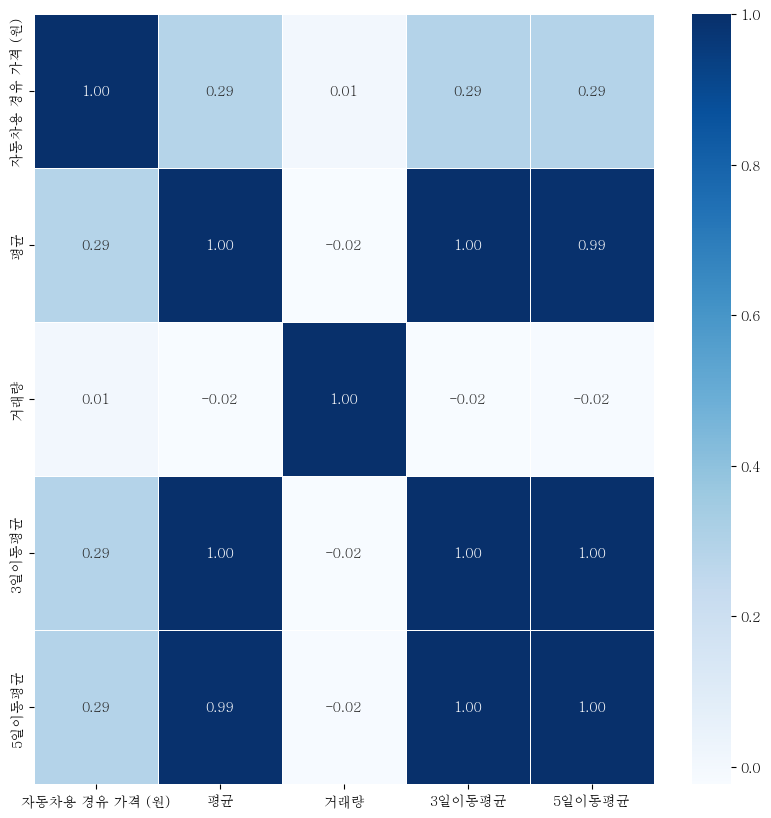

In [611]:
print(lstm_df.corr(method='pearson'))

# 상관관계 시각화
plt.figure(figsize=(10,10))
sns.heatmap(lstm_df.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()


In [563]:
# 정규화 작업(date 를 제외한 항목을 제외한 숫자로 표현되는 모든 column에 대해 0~1 값으로 정규화 작업을 수행)
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scale_cols1 = ['자동차용 경유 가격 (원)', '거래량', '3일이동평균', '5일이동평균'] #정규화 대상 column 정의
scale_cols2 = ['평균']
scaled_df1 = scaler.fit_transform(lstm_df[scale_cols1]) # 정규화 수행
print(type(scaled_df1), '\n') # 리턴값 확인하면 numpy.ndarray임을 알 수 있음 -> 데이터프레임으로 변환해서 사용해야함
scaled_df2 = scaler.fit_transform(lstm_df[scale_cols2]) # 정규화 수행
print(type(scaled_df2), '\n')

# 정규화된 데이터를 데이터프레임으로 변환
scaled_df1 = pd.DataFrame(scaled_df1, columns=scale_cols1) #정규화된 새로운 dataframe 생성
scaled_df2= pd.DataFrame(scaled_df2, columns=scale_cols2) #정규화된 새로운 dataframe 생성
print(scaled_df1)
print(scaled_df2)

<class 'numpy.ndarray'> 

<class 'numpy.ndarray'> 

      자동차용 경유 가격 (원)       거래량    3일이동평균    5일이동평균
0          -1.889766 -1.064609 -0.277644 -0.254523
1          -1.889766 -1.064609 -0.277644 -0.254523
2          -1.889766 -1.064609 -0.277644 -0.254523
3          -1.889766  0.489666 -0.277644 -0.254523
4          -1.889766 -0.460489 -0.276064 -0.277335
...              ...       ...       ...       ...
8365        1.616293 -0.572849 -0.159102 -0.151869
8366        1.616293 -0.572849 -0.159102 -0.159473
8367        1.616293 -0.813125 -0.193558 -0.180194
8368        1.616293 -1.128384 -0.233705 -0.204336
8369        1.616293 -1.020246 -0.301511 -0.245113

[8370 rows x 4 columns]
            평균
0    -0.277001
1    -0.277001
2    -0.277001
3    -0.277001
4    -0.272270
...        ...
8365 -0.158730
8366 -0.158730
8367 -0.261863
8368 -0.278894
8369 -0.361683

[8370 rows x 1 columns]


In [564]:
# 딥러닝 학습을 위한 입력데이터 feature column , 정답데이터 column 정의 후 numpy 로 변환하여 데이터 전처리 과정 완료하기
feature_cols = ['자동차용 경유 가격 (원)', '거래량', '3일이동평균', '5일이동평균'] #feature 정의(입력데이터)
label_cols = ['평균'] #label 정의(정답데이터)

feature_df = pd.DataFrame(scaled_df1, columns=feature_cols)  #feature 데이터프레임 생성
label_df = pd.DataFrame(scaled_df2, columns=label_cols) #label 데이터프레임 생성

print(feature_df)
print(label_df)

# 딥러닝 학습을 위해 dataframe 에서 numpy 로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

      자동차용 경유 가격 (원)       거래량    3일이동평균    5일이동평균
0          -1.889766 -1.064609 -0.277644 -0.254523
1          -1.889766 -1.064609 -0.277644 -0.254523
2          -1.889766 -1.064609 -0.277644 -0.254523
3          -1.889766  0.489666 -0.277644 -0.254523
4          -1.889766 -0.460489 -0.276064 -0.277335
...              ...       ...       ...       ...
8365        1.616293 -0.572849 -0.159102 -0.151869
8366        1.616293 -0.572849 -0.159102 -0.159473
8367        1.616293 -0.813125 -0.193558 -0.180194
8368        1.616293 -1.128384 -0.233705 -0.204336
8369        1.616293 -1.020246 -0.301511 -0.245113

[8370 rows x 4 columns]
            평균
0    -0.277001
1    -0.277001
2    -0.277001
3    -0.277001
4    -0.272270
...        ...
8365 -0.158730
8366 -0.158730
8367 -0.261863
8368 -0.278894
8369 -0.361683

[8370 rows x 1 columns]


In [565]:
# 입력 파라미터 feature, label => numpy type 함수로 만들기 
def make_sequene_dataset(feature, label, window_size):
    feature_list = [] # 생성될 feature list
    label_list = [] # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size]) 
        #feature[i:i+window_size] => 2차원 배열, 슬라이싱 이용하여 [[..], [..],..] 형상으로 입력 데이터, feature를 생성함
        label_list.append(label[i+window_size]) # 2차원 행렬의 배열
    
    return np.array(feature_list), np.array(label_list)  # 3차원 배열로 리턴
    #feature_list = [ [..], [..], ..] 이므로 리턴값 np.array(feature_list)는 (batch_size, time steps, input dims형상을 가짐

In [566]:
# 학습데이터 X, Y 생성
window_size = 20 #앞에 40개 데이터를 이용해서 그 다음 정답데이터 label 를 예측한다는 뜻
X, Y = make_sequene_dataset(feature_np, label_np, window_size) #make_sequence_data 함수를 이용해서 X, Y 생성
print(X.shape, Y.shape)

(8350, 20, 4) (8350, 1)


In [567]:
split = -1666 #(전체 데이터에 *20% ) 트레인 데이터, 테스트 데이터 분리

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6684, 20, 4) (6684, 1)
(1666, 20, 4) (1666, 1)


In [589]:
# model = Sequential()
# model.add(LSTM(64, 
#                input_shape=x_train[0].shape, 
#                activation='relu', 
#                return_sequences=False)
#           )
# model.add(Dense(128, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='relu'))
#----------------------------------------------

model = Sequential()
model.add(LSTM(64, activation='tanh', #LSTM 레이어에서 tanh 를 활성화 함수로 가지는 노드 수 128개
               input_shape=x_train[0].shape)) #input_sape=(40, 2) 40개의 데이터를 2개씩 입력받음
model.add(Dropout(0.3)) #Dropout 레이어에서 30% 노드를 랜덤하게 제거
model.add(Dense(1, activation='linear'))

model.summary()
#----------------------------------------------
# model = Sequential([
#     # 1차원 feature map 생성
#     Conv1D(filters=32, kernel_size=5,
#            padding="causal",
#            activation="relu",
#            input_shape=x_train[0].shape),
#     Dropout(0.3)
#     # LSTM
#     LSTM(128, activation='tanh'),
#     Dense(64),
#     Dense(32),
#     Dense(16, activation="relu"),
#     Dense(1),
# ])

# model.summary()
#----------------------------------------------
# model = Sequential()
# # LSTM 모델을 만든다
# model.add(LSTM(32, input_shape=x_train[0].shape, return_sequences=True))
# # maxpooling
# model.add(MaxPooling1D(pool_size=2))
# # flatten
# model.add(Flatten())
# model.add(Dense(1))
# model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                17664     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [590]:
#모델 컴파일 및 학습
#조기종료 셋팅  : EarlyStopping
#checkpoint 셋팅 : ModelCheckpoint 사용

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae']) #metrics 관찰대상(mae = 평균절대오차값)
early_stop = EarlyStopping(monitor='val_loss', patience=10) #val_loss 가 5번 이상 개선되지 않으면 학습 중단
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, callbacks=[early_stop])
#----------------------------------------------
# model.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# model_path = 'model'
# filename = os.path.join(model_path, 'lstm_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
# history = model.fit(x_train, y_train, epochs=200, batch_size=64,
#                     validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100
105/105 [==============================] - 7s 34ms/step - loss: 0.1030 - mae: 0.2067 - val_loss: 0.1758 - val_mae: 0.2235
Epoch 2/100
105/105 [==============================] - 3s 27ms/step - loss: 0.0362 - mae: 0.1325 - val_loss: 0.1261 - val_mae: 0.1978
Epoch 3/100
105/105 [==============================] - 2s 21ms/step - loss: 0.0318 - mae: 0.1224 - val_loss: 0.0941 - val_mae: 0.1819
Epoch 4/100
105/105 [==============================] - 2s 22ms/step - loss: 0.0264 - mae: 0.1119 - val_loss: 0.0847 - val_mae: 0.1751
Epoch 5/100
105/105 [==============================] - 2s 21ms/step - loss: 0.0264 - mae: 0.1097 - val_loss: 0.0737 - val_mae: 0.1650
Epoch 6/100
105/105 [==============================] - 2s 19ms/step - loss: 0.0246 - mae: 0.1046 - val_loss: 0.0741 - val_mae: 0.1635
Epoch 7/100
105/105 [==============================] - 3s 24ms/step - loss: 0.0238 - mae: 0.1023 - val_loss: 0.0782 - val_mae: 0.1600
Epoch 8/100
105/105 [==============================] - 4s 40ms

53/53 [==============================] - 2s 11ms/step


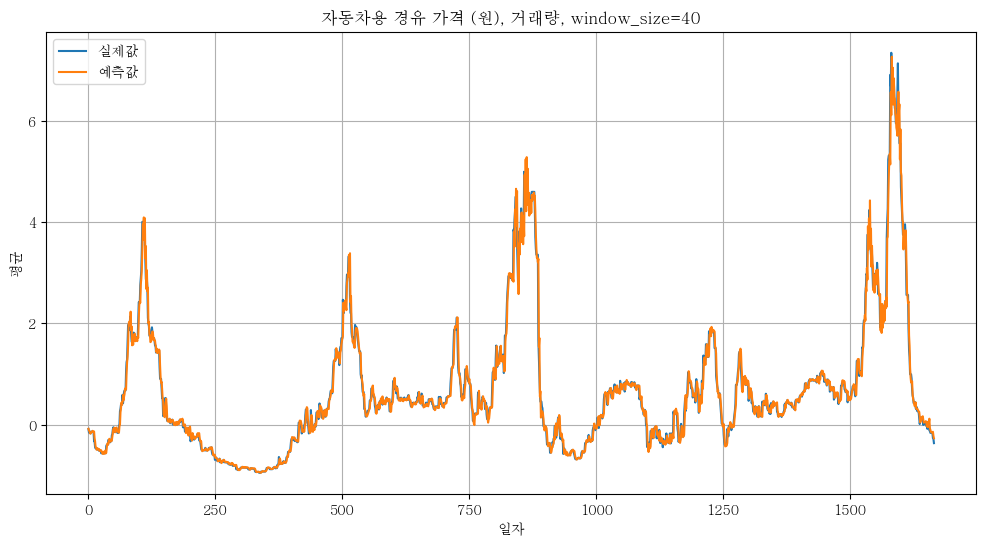

In [591]:
# 주가 예측
pred = model.predict(x_test) 

plt.figure(figsize=(12, 6))
plt.title('자동차용 경유 가격 (원), 거래량, window_size=40')
plt.ylabel('평균')
plt.xlabel('일자')
plt.plot(y_test, label='실제값')
plt.plot(pred, label='예측값')
plt.grid()
plt.legend(loc='best')

plt.show()

In [596]:
#  모델을 평가한다
#  RMSE
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))
print('R2 :', r2_score(y_test, test_predict))


53/53 [==============================] - 3s 52ms/step
Train Score: 0.08 RMSE
Test Score: 0.18 RMSE
R2 : 0.9824425320920356


In [593]:
# LSTM 모델 저장하기
model.save_weights('lstm_model_hy')

In [594]:
load_model = Sequential()
load_model.add(LSTM(64, activation='tanh', #LSTM 레이어에서 tanh 를 활성화 함수로 가지는 노드 수 128개
               input_shape=x_train[0].shape)) #input_sape=(40, 2) 40개의 데이터를 2개씩 입력받음
load_model.add(Dropout(0.3)) #Dropout 레이어에서 30% 노드를 랜덤하게 제거
load_model.add(Dense(1, activation='linear'))

load_model.load_weights('lstm_model_hy')
load_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                17664     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________
